<a href="https://colab.research.google.com/github/SC1DR-OFFICIAL/Simple-RL-for-Atari-MsPacman/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Statement of the problem

1. Using Gym Atari, choose a game with more than 4 actions (Take Pac-Man)
2. Train the game on different strategies: Random Search, Hill Climbing, Gradient Policy, Evolution Strategies.
3. Create a video of several game episodes in which the model achieved the maximum reward.
4. Compare the algorithms.

# Initialization of necessary libraries and functions

## Connecting Drive
To save models

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Installing Atari

In [ ]:
!pip install "gymnasium[atari]"
!pip install autorom[accept-rom-license]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 8.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for AutoROM.accept-rom-license: filename=autorom_accept_rom_license-0.6.1-py3-none-any.whl size=446709 sha256=8cafabad6f82e272c9f0c80add9f45b9189211c4c846eb06c61e58c761765ed8
  Stored in directory: /root/.cache/pip/wheels/99/f1/ff/c6966c034a8259164bdc9deb4d1ea839f119474638100e6645
Successfully built AutoROM.accept-rom-license


## Registering the environment

In [ ]:
import gymnasium as gym
import ale_py

gym.register_envs(ale_py)

## Creating an environment for Pac-Man

In [ ]:
env = gym.make("ALE/MsPacman-v5", repeat_action_probability=0.0)

## Import libraries and check environment

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical

import cv2
import numpy as np

import os, glob
from gymnasium.wrappers import RecordVideo
from IPython.display import Video

import matplotlib.pyplot as plt

from collections import deque

Let's check the dimension of states and the number of actions:

In [ ]:
obs, info = env.reset()
print("Shape obs:", obs.shape)
print("Num actions:", env.action_space.n)

Shape obs: (210, 160, 3)
Num actions: 9


## Episode Playback Function

Runs `n_eval_episodes` episodes with the given policy.
- Calculates the total reward for each episode.
- If `record_video=True`, writes videos of all episodes to `video_dir`.
- Prints statistics (average, min, max).
- Builds a histogram of the reward distribution.

Returns the list of rewards.

In [ ]:
def evaluate(env_id, policy, n_eval_episodes=100, record_video=False,
             video_dir="/content/videos", name_prefix="eval"):

    if record_video:
        env = RecordVideo(
            gym.make(env_id, render_mode="rgb_array", repeat_action_probability=0.0),
            video_folder=video_dir,
            episode_trigger=lambda ep: True,
            name_prefix=name_prefix
        )
    else:
        env = gym.make(env_id, repeat_action_probability=0.0)

    rewards = []
    for ep in range(n_eval_episodes):
        obs, _ = env.reset()
        done, total = False, 0.0
        while not done:
            obs_t = preprocess(obs)
            with torch.no_grad():
                dist = policy(obs_t)
                act = dist.sample().item()
            obs, r, term, trunc, _ = env.step(act)
            total += r
            done = term or trunc
        rewards.append(total)
        print(f"[{name_prefix}] Episode {ep+1}/{n_eval_episodes}: reward={total}")

    env.close()

    # statistics
    print("Average reward:", np.mean(rewards))
    print("Min:", np.min(rewards), "Max:", np.max(rewards))

    # histogram
    plt.hist(rewards, bins=20)
    plt.xlabel("Reward")
    plt.ylabel("Frequency")
    plt.title(f"{name_prefix}: distribution over {n_eval_episodes} episodes")
    plt.show()

    return rewards

## Episode Collection Cycle

Runs one episode: plays until the end of Wednesday, applying `policy`, saves the log probabilities of the actions taken (`log_probs`) and the rewards received (`rewards`), and then returns both lists.

In [ ]:
def run_episode(env, policy, gamma=0.99):
    log_probs, rewards = [], []
    obs, _ = env.reset()
    done = False
    while not done:
        obs_t = preprocess(obs)
        dist = policy(obs_t)
        action = dist.sample()
        log_probs.append(dist.log_prob(action))

        obs, reward, terminated, truncated, _ = env.step(action.item())
        rewards.append(reward)
        done = terminated or truncated
    return log_probs, rewards

## Image preprocessing

Atari produces large RGB frames. For Policy Gradient it is more convenient to reduce them and convert them to grayscale:

In [ ]:
def preprocess(obs):
    # Reduce and convert to shades of gray
    obs = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
    obs = cv2.resize(obs, (84, 84))
    obs = obs / 255.0
    return torch.tensor(obs, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

## Find the episode with the maximum reward

Runs `n_episodes` episodes with the given policy.
For each episode:
- calculates the total reward,
- automatically records a video of the playthrough,
- displays the reward in the console.

Returns a list of total rewards.

In [ ]:
def collect_and_record(env_id, policy, n_episodes=10, video_dir="/content/videos", name_prefix="pg"):
    rewards = []
    env = RecordVideo(
        gym.make(env_id, render_mode="rgb_array", repeat_action_probability=0.0),
        video_folder=video_dir,
        episode_trigger=lambda e: True,
        name_prefix=name_prefix
    )
    for ep in range(n_episodes):
        obs, _ = env.reset()
        done, total = False, 0.0
        while not done:
            obs_t = preprocess(obs)
            with torch.no_grad():
                dist = policy(obs_t)
                act = dist.sample().item()
            obs, r, terminated, truncated, _ = env.step(act)
            total += r
            done = terminated or truncated
        rewards.append(total)
        print(f"[{name_prefix}] Episode {ep+1}/{n_episodes}: reward={total}")
    env.close()
    return rewards

## Definition of Policy Network

In [ ]:
class Policy(nn.Module):
    def __init__(self, num_actions):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, 8, stride=4), nn.ReLU(),
            nn.Conv2d(16, 32, 4, stride=2), nn.ReLU()
        )
        self.fc = nn.Sequential(
            nn.Linear(32*9*9, 256), nn.ReLU(),
            nn.Linear(256, num_actions)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        return Categorical(logits=logits)

# Random Search Method

- This is one of the simplest optimization methods.
The idea is to try many random strategies and choose the best one.

- At each iteration, new strategy parameters are randomly generated.
The strategy is launched in the environment, and the total reward is calculated.

- If the new strategy works better than all the previous ones, it is saved.
The process is repeated a specified number of times.

- Limitations:
The method does not use any information about which way the strategy needs to be improved.
Therefore, it is not suitable for problems with a large number of parameters, but can work in simple cases.

## Initializing variables for Random Search

In [ ]:
n_episode_random = 200          # number of strategy candidates
n_eval_per_candidate = 5        # episodes to evaluate one strategy

best_reward_rs = -float("inf")  # best reward found
best_state_dict_rs = None       # weights of the best strategy
random_search_rewards = []      # history of average awards by candidates

## Strategy Evaluation Function

In [ ]:
def evaluate_policy_rs(env_id, policy, n_eval_episodes=5):
    env = gym.make(env_id, repeat_action_probability=0.0)
    rewards = []
    for _ in range(n_eval_episodes):
        obs, _ = env.reset()
        done, total = False, 0.0
        while not done:
            obs_t = preprocess(obs)
            with torch.no_grad():
                dist = policy(obs_t)
                act = dist.sample().item()
            obs, r, term, trunc, _ = env.step(act)
            total += r
            done = term or trunc
        rewards.append(total)
    env.close()
    return np.mean(rewards)

## Main Loop Random Search

In [ ]:
for i in range(n_episode_random):
    # 1) generate a random strategy
    cand = Policy(env.action_space.n)

    #2) evaluate it
    score = evaluate_policy_rs("ALE/MsPacman-v5", cand, n_eval_episodes=n_eval_per_candidate)
    random_search_rewards.append(score)

    #3) update the best result
    if score > best_reward_rs:
        best_reward_rs = score
        best_state_dict_rs = cand.state_dict()

    print(f"[RandomSearch] Candidate {i+1}/{n_episode_random}: mean_reward={score:.1f}")

print("Best average reward (Random Search):", best_reward_rs)

[RandomSearch] Candidate 1/200: mean_reward=200.0
[RandomSearch] Candidate 2/200: mean_reward=222.0
[RandomSearch] Candidate 3/200: mean_reward=256.0
[RandomSearch] Candidate 4/200: mean_reward=354.0
[RandomSearch] Candidate 5/200: mean_reward=342.0
[RandomSearch] Candidate 6/200: mean_reward=222.0
[RandomSearch] Candidate 7/200: mean_reward=244.0
[RandomSearch] Candidate 8/200: mean_reward=222.0
[RandomSearch] Candidate 9/200: mean_reward=240.0
[RandomSearch] Candidate 10/200: mean_reward=248.0
[RandomSearch] Candidate 11/200: mean_reward=226.0
[RandomSearch] Candidate 12/200: mean_reward=210.0
[RandomSearch] Candidate 13/200: mean_reward=186.0
[RandomSearch] Candidate 14/200: mean_reward=240.0
[RandomSearch] Candidate 15/200: mean_reward=252.0
[RandomSearch] Candidate 16/200: mean_reward=228.0
[RandomSearch] Candidate 17/200: mean_reward=222.0
[RandomSearch] Candidate 18/200: mean_reward=266.0
[RandomSearch] Candidate 19/200: mean_reward=226.0
[RandomSearch] Candidate 20/200: mean_re

## Saving the best Random Search model

In [ ]:
save_path_rs = "/content/drive/MyDrive/random_search_policy.pth"
torch.save(best_state_dict_rs, save_path_rs)
print("Random Search policy save in:", save_path_rs)

Random Search policy save in: /content/drive/MyDrive/random_search_policy.pth


## Schedule

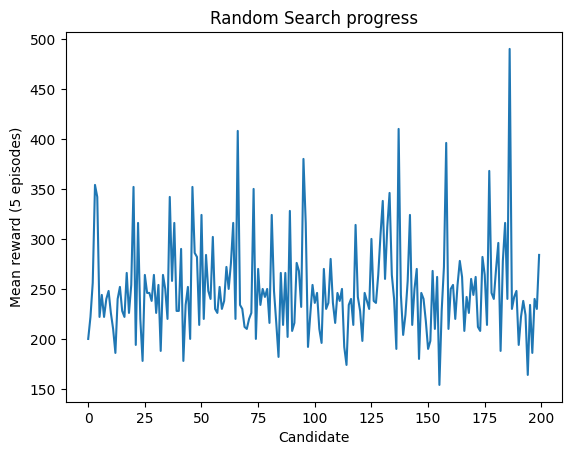

In [ ]:
plt.plot(random_search_rewards)
plt.xlabel("Candidate")
plt.ylabel("Mean reward (5 episodes)")
plt.title("Random Search progress")
plt.show()

1. **Start (up to ~50 candidates)**  
   – Average rewards remain in the 200–300 range.  
   – There are rare spikes up to 350–400, but they are unstable.  

2. **Middle (50–150 candidates)**  
   – Rewards continue to fluctuate within 200–300.  
   – Occasional peaks appear above 400.  
   – Overall spread remains large, with no consistent growth.  

3. **After 150 candidates**  
   – Results are the same: average level ≈200–250, with isolated peaks closer to 500.  
   – However, high rewards are not reproducible, the strategy is random each time.  

4. **Overall trend**  
   – The method shows no learning: the average level stays at a random baseline.  
   – Peaks are just lucky random strategies, but they do not persist.  
   – Random Search provides insight that some strategies work better, but it does not accumulate experience or systematically improve behavior.  


## Launch of the best episodes of Random Search

[RandomSearch] Episode 1/50: reward=200.0
[RandomSearch] Episode 2/50: reward=310.0
[RandomSearch] Episode 3/50: reward=260.0
[RandomSearch] Episode 4/50: reward=190.0
[RandomSearch] Episode 5/50: reward=200.0
[RandomSearch] Episode 6/50: reward=270.0
[RandomSearch] Episode 7/50: reward=210.0
[RandomSearch] Episode 8/50: reward=150.0
[RandomSearch] Episode 9/50: reward=200.0
[RandomSearch] Episode 10/50: reward=170.0
[RandomSearch] Episode 11/50: reward=210.0
[RandomSearch] Episode 12/50: reward=650.0
[RandomSearch] Episode 13/50: reward=380.0
[RandomSearch] Episode 14/50: reward=180.0
[RandomSearch] Episode 15/50: reward=1150.0
[RandomSearch] Episode 16/50: reward=230.0
[RandomSearch] Episode 17/50: reward=250.0
[RandomSearch] Episode 18/50: reward=190.0
[RandomSearch] Episode 19/50: reward=290.0
[RandomSearch] Episode 20/50: reward=370.0
[RandomSearch] Episode 21/50: reward=290.0
[RandomSearch] Episode 22/50: reward=220.0
[RandomSearch] Episode 23/50: reward=260.0
[RandomSearch] Epis

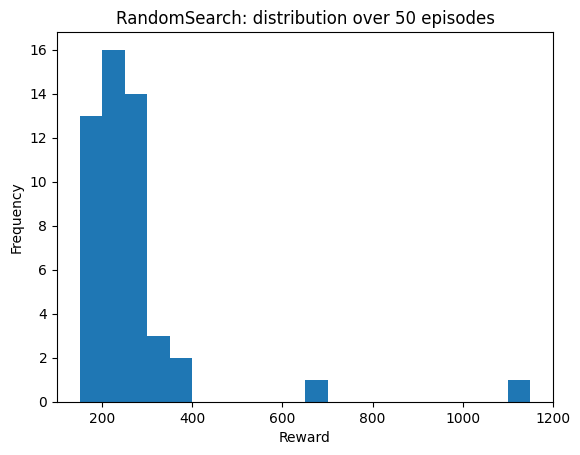

Top episodes: [14 11 12] Rewards: [1150.0, 650.0, 380.0]


In [ ]:
# Loading the best strategy
rs_policy = Policy(env.action_space.n)
rs_policy.load_state_dict(torch.load(save_path_rs))
rs_policy.eval()

# Let's play 50 episodes with video recording
rewards_rs = evaluate("ALE/MsPacman-v5", rs_policy, n_eval_episodes=50,
                      record_video=True, video_dir="/content/videos", name_prefix="RandomSearch")

# Let's find the top 3 episodes
top_k = 3
best_ids_rs = np.argsort(rewards_rs)[-top_k:][::-1]
print("Top episodes:", best_ids_rs, "Rewards:", [rewards_rs[i] for i in best_ids_rs])

# Show videos of the best episodes
for idx in best_ids_rs:
    video_path = f"/content/videos/RandomSearch-episode-{idx}.mp4"
    display(Video(video_path, embed=True))

# Hill Climbing Method

- This is an optimization method that improves a strategy in small steps.
- Unlike random search, where completely new strategies are tried each time,
Hill Climbing takes the current strategy and randomly modifies it slightly.

- If the new strategy is better (gives more reward), it becomes the current one.
- If it is worse, it is discarded and the search continues.

- Thus, the strategy gradually "climbs" along the surface of the reward function.

- Limitations:
The method can get stuck in a local maximum,
since it always accepts only improvements and does not explore worse options.

## Initializing Hill Climbing Variables

In [ ]:
n_episode_hc = 200        # number of iterations (mutated strategies)
n_eval_per_candidate = 5  # episodes to evaluate one strategy
mutation_scale = 0.02     # amplitude of random weight change

best_policy_hc = Policy(env.action_space.n) # initial strategy
best_reward_hc = evaluate_policy_rs("ALE/MsPacman-v5", best_policy_hc, n_eval_episodes=n_eval_per_candidate)
best_state_dict_hc = best_policy_hc.state_dict()
hc_rewards = [best_reward_hc]

## Implementation of Hill Climbing

In [ ]:
print(f"[HillClimbing] Initial mean_reward={best_reward_hc:.1f}")

for i in range(1, n_episode_hc+1):
    # 1) create a mutated copy of the current best strategy
    candidate = Policy(env.action_space.n)
    candidate.load_state_dict(best_state_dict_hc)
    with torch.no_grad():
        for p in candidate.parameters():
            p += mutation_scale * torch.randn_like(p)

    #2) evaluate the candidate
    score = evaluate_policy_rs("ALE/MsPacman-v5", candidate, n_eval_episodes=n_eval_per_candidate)

    #3) accept the candidate if he is better
    if score > best_reward_hc:
        best_reward_hc = score
        best_state_dict_hc = candidate.state_dict()
        print(f"[HillClimbing] Iter {i}/{n_episode_hc}: improved mean_reward={score:.1f}")
    else:
        print(f"[HillClimbing] Iter {i}/{n_episode_hc}: worse mean_reward={score:.1f}")

    hc_rewards.append(best_reward_hc)

print("Best average reward (Hill Climbing):", best_reward_hc)

[HillClimbing] Initial mean_reward=220.0
[HillClimbing] Iter 1/200: improved mean_reward=248.0
[HillClimbing] Iter 2/200: worse mean_reward=218.0
[HillClimbing] Iter 3/200: worse mean_reward=240.0
[HillClimbing] Iter 4/200: worse mean_reward=208.0
[HillClimbing] Iter 5/200: improved mean_reward=254.0
[HillClimbing] Iter 6/200: worse mean_reward=226.0
[HillClimbing] Iter 7/200: improved mean_reward=384.0
[HillClimbing] Iter 8/200: worse mean_reward=276.0
[HillClimbing] Iter 9/200: worse mean_reward=248.0
[HillClimbing] Iter 10/200: worse mean_reward=220.0
[HillClimbing] Iter 11/200: worse mean_reward=290.0
[HillClimbing] Iter 12/200: worse mean_reward=318.0
[HillClimbing] Iter 13/200: worse mean_reward=342.0
[HillClimbing] Iter 14/200: worse mean_reward=216.0
[HillClimbing] Iter 15/200: worse mean_reward=286.0
[HillClimbing] Iter 16/200: worse mean_reward=264.0
[HillClimbing] Iter 17/200: worse mean_reward=262.0
[HillClimbing] Iter 18/200: worse mean_reward=248.0
[HillClimbing] Iter 19/

## Saving the model

In [ ]:
save_path_hc = "/content/drive/MyDrive/hill_climbing_policy.pth"
torch.save(best_state_dict_hc, save_path_hc)
print("Hill Climbing policy save in:", save_path_hc)

Hill Climbing policy save in: /content/drive/MyDrive/hill_climbing_policy.pth


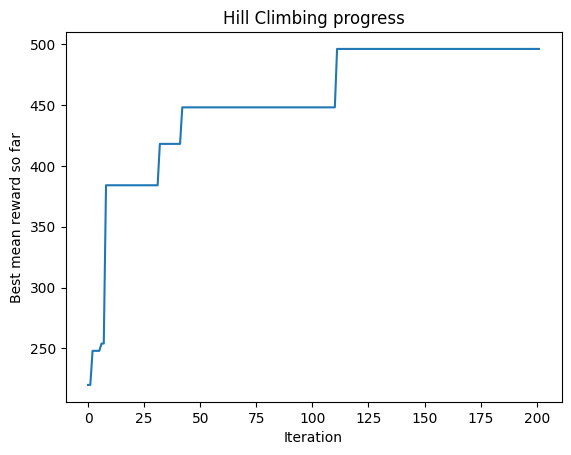

In [ ]:
plt.plot(hc_rewards)
plt.xlabel("Iteration")
plt.ylabel("Best mean reward so far")
plt.title("Hill Climbing progress")
plt.show()

1. **Start (first 10 iterations)**  
   – The initial strategy shows a low result (~220).  
   – Quick improvements are found up to 250–260, then a sharp jump to ~380.  

2. **Middle (10–50 iterations)**  
   – Gradual improvements: rewards rise first to ~420, then to ~450.  
   – Each new improvement is consolidated as the best result.  

3. **After 100 iterations**  
   – Long plateau at the 450 level.  
   – Only around the 110th iteration a new improvement is found (~495).  
   – Further (up to 200 iterations) no growth is observed: the algorithm got stuck in a local maximum.  

4. **Overall trend**  
   – Hill Climbing indeed improves the strategy step by step.  
   – There is a visible gradual accumulation of progress and consolidation of best results.  
   – However, after a certain level (~500 points) the algorithm stopped finding improvements — a limitation of the method: the tendency to get stuck in a local maximum.  


## Hill Climbing's Best Episodes Launch

[HillClimb] Episode 1/50: reward=130.0
[HillClimb] Episode 2/50: reward=430.0
[HillClimb] Episode 3/50: reward=210.0
[HillClimb] Episode 4/50: reward=160.0
[HillClimb] Episode 5/50: reward=220.0
[HillClimb] Episode 6/50: reward=390.0
[HillClimb] Episode 7/50: reward=190.0
[HillClimb] Episode 8/50: reward=240.0
[HillClimb] Episode 9/50: reward=1080.0
[HillClimb] Episode 10/50: reward=220.0
[HillClimb] Episode 11/50: reward=190.0
[HillClimb] Episode 12/50: reward=680.0
[HillClimb] Episode 13/50: reward=240.0
[HillClimb] Episode 14/50: reward=200.0
[HillClimb] Episode 15/50: reward=210.0
[HillClimb] Episode 16/50: reward=450.0
[HillClimb] Episode 17/50: reward=360.0
[HillClimb] Episode 18/50: reward=310.0
[HillClimb] Episode 19/50: reward=220.0
[HillClimb] Episode 20/50: reward=320.0
[HillClimb] Episode 21/50: reward=390.0
[HillClimb] Episode 22/50: reward=250.0
[HillClimb] Episode 23/50: reward=190.0
[HillClimb] Episode 24/50: reward=260.0
[HillClimb] Episode 25/50: reward=220.0
[HillCli

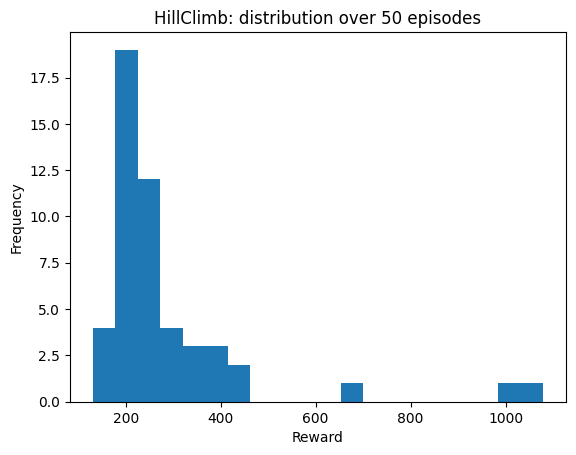

Top episodes: [ 8 47 11] Rewards: [1080.0, 1000.0, 680.0]


In [ ]:
# Load the best Hill Climbing policy
hc_policy = Policy(env.action_space.n)
hc_policy.load_state_dict(torch.load(save_path_hc))
hc_policy.eval()

# Play 50 episodes with video recording
rewards_hc = evaluate("ALE/MsPacman-v5", hc_policy, n_eval_episodes=50,
                      record_video=True, video_dir="/content/videos", name_prefix="HillClimb")

# Find the top-3 episodes
top_k = 3
best_ids_hc = np.argsort(rewards_hc)[-top_k:][::-1]
print("Top episodes:", best_ids_hc, "Rewards:", [rewards_hc[i] for i in best_ids_hc])

# Display videos of the best episodes
for idx in best_ids_hc:
    video_path = f"/content/videos/HillClimb-episode-{idx}.mp4"
    display(Video(video_path, embed=True))


# Policy Gradient Method

- The agent learns a policy that assigns probabilities of choosing actions in each state.  

- The goal of training is to make the policy yield as many rewards as possible on average.  

- The REINFORCE algorithm updates policy parameters after each episode:  
  if actions led to a high reward — their selection probability increases,  
  if to a low reward — their probability decreases.  

- As a result, the policy gradually adapts to choose successful actions more often and unsuccessful ones less often.  


## Learning function (REINFORCE)

In [ ]:
def update_policy(optimizer, log_probs, rewards, gamma=0.99):
    returns, G = [], 0
    for r in reversed(rewards):
        G = r + gamma*G
        returns.insert(0, G)
    returns = torch.tensor(returns, dtype=torch.float32)
    returns = (returns - returns.mean()) / (returns.std() + 1e-8)

    loss = []
    for log_prob, Gt in zip(log_probs, returns):
        loss.append(-log_prob * Gt)
    loss = torch.stack(loss).sum()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

## Initialization of variables

In [ ]:
n_episode = 1000                # number of episodes
learning_rate = 1e-4            # learning rate
gamma = 0.99                    # discount factor

policy = Policy(env.action_space.n)
optimizer = optim.Adam(policy.parameters(), lr=learning_rate)

total_rewards = []              # list to store rewards

## Basic training cycle

In [ ]:
for episode in range(n_episode):
    # 1. Play one episode with the current policy
    log_probs, rewards = run_episode(env, policy, gamma)

    # 2. Update network weights using the REINFORCE algorithm
    update_policy(optimizer, log_probs, rewards, gamma)

    # 3. Calculate total reward for the episode
    total_reward = sum(rewards)
    total_rewards.append(total_reward)

    # 4. Print progress
    print(f"[GradientPolicy] Episode {episode+1}/{n_episode}: total_reward={total_reward:.1f}")

[GradientPolicy] Episode 1/1000: total_reward=210.0
[GradientPolicy] Episode 2/1000: total_reward=180.0
[GradientPolicy] Episode 3/1000: total_reward=200.0
[GradientPolicy] Episode 4/1000: total_reward=220.0
[GradientPolicy] Episode 5/1000: total_reward=250.0
[GradientPolicy] Episode 6/1000: total_reward=220.0
[GradientPolicy] Episode 7/1000: total_reward=240.0
[GradientPolicy] Episode 8/1000: total_reward=330.0
[GradientPolicy] Episode 9/1000: total_reward=170.0
[GradientPolicy] Episode 10/1000: total_reward=230.0
[GradientPolicy] Episode 11/1000: total_reward=310.0
[GradientPolicy] Episode 12/1000: total_reward=230.0
[GradientPolicy] Episode 13/1000: total_reward=140.0
[GradientPolicy] Episode 14/1000: total_reward=210.0
[GradientPolicy] Episode 15/1000: total_reward=300.0
[GradientPolicy] Episode 16/1000: total_reward=390.0
[GradientPolicy] Episode 17/1000: total_reward=170.0
[GradientPolicy] Episode 18/1000: total_reward=280.0
[GradientPolicy] Episode 19/1000: total_reward=620.0
[G

## Saving the model

In [ ]:
save_path_pg = "/content/drive/MyDrive/gradient_policy.pth"
torch.save(policy.state_dict(), save_path_pg)
print("Policy Gradient save in:", save_path_pg)

Policy Gradient save in: /content/drive/MyDrive/gradient_policy.pth


Let us calculate the average total reward obtained in the strategy gradient algorithm:

In [ ]:
print('Average total reward over {} episodes: {}'.format(n_episode, sum(total_rewards) / n_episode))

Average total reward over 1000 episodes: 526.94


Let's plot a graph of the total reward as a function of the episode number:

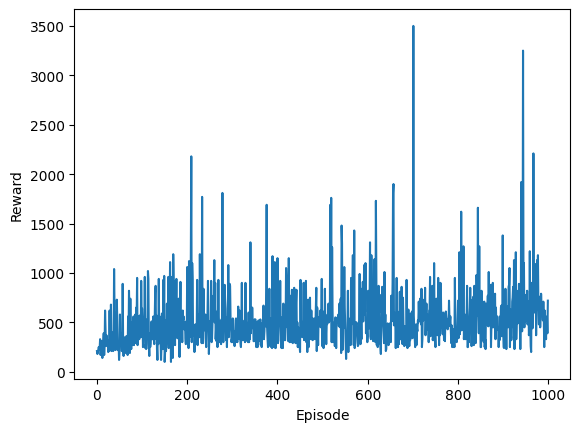

In [ ]:
plt.plot(total_rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

1. **Start (up to ~200 episodes)**  
   – The agent plays roughly at the level of a random strategy, with average rewards of 200–400.  
   – Occasionally there are spikes up to 800–1000, but they are rare.  

2. **Middle of training (200–600 episodes)**  
   – Rewards become more diverse, values of 400–700 appear more often.  
   – Peaks up to 1500–2000 occur, but infrequently.  
   – Training remains very noisy.  

3. **After 600 episodes**  
   – The average level stays in the same range (400–700).  
   – Sometimes the policy randomly finds good trajectories, leading to spikes up to 2500–3500.  
   – However, the agent cannot sustain such results.  

4. **Overall trend**  
   – There is slight improvement compared to random behavior.  
   – But the curve remains extremely noisy, with high variance.  
   – The Policy Gradient (REINFORCE) algorithm does not form a stable strategy: improvements are unstable and highly dependent on lucky episodes.  


**Let's see how the learned strategy will behave in 50 new episodes.**

## View

[GradientPolicy] Episode 1/50: reward=1080.0
[GradientPolicy] Episode 2/50: reward=1100.0
[GradientPolicy] Episode 3/50: reward=400.0
[GradientPolicy] Episode 4/50: reward=650.0
[GradientPolicy] Episode 5/50: reward=1030.0
[GradientPolicy] Episode 6/50: reward=440.0
[GradientPolicy] Episode 7/50: reward=500.0
[GradientPolicy] Episode 8/50: reward=730.0
[GradientPolicy] Episode 9/50: reward=460.0
[GradientPolicy] Episode 10/50: reward=380.0
[GradientPolicy] Episode 11/50: reward=820.0
[GradientPolicy] Episode 12/50: reward=790.0
[GradientPolicy] Episode 13/50: reward=240.0
[GradientPolicy] Episode 14/50: reward=790.0
[GradientPolicy] Episode 15/50: reward=360.0
[GradientPolicy] Episode 16/50: reward=760.0
[GradientPolicy] Episode 17/50: reward=500.0
[GradientPolicy] Episode 18/50: reward=520.0
[GradientPolicy] Episode 19/50: reward=1120.0
[GradientPolicy] Episode 20/50: reward=710.0
[GradientPolicy] Episode 21/50: reward=660.0
[GradientPolicy] Episode 22/50: reward=460.0
[GradientPolicy

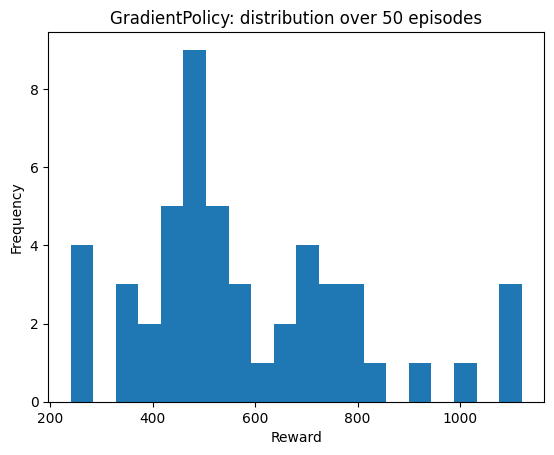

Top episodes: [18  1  0] Rewards: [1120.0, 1100.0, 1080.0]


In [ ]:
# 1. Play several episodes with video recording
rewards = evaluate("ALE/MsPacman-v5", policy, n_eval_episodes=50,
                   record_video=True, video_dir="/content/videos", name_prefix="GradientPolicy")

# 2. Find indices of the top-3 episodes by reward
top_k = 3
best_ids = np.argsort(rewards)[-top_k:][::-1]
print("Top episodes:", best_ids, "Rewards:", [rewards[i] for i in best_ids])

# 3. Display videos of these episodes
for idx in best_ids:
    video_path = f"/content/videos/GradientPolicy-episode-{idx}.mp4"
    display(Video(video_path, embed=True))


# Evolution Strategies (ES)

- The method belongs to the family of evolutionary algorithms.  
- Instead of a single "candidate," a population of policies is maintained.  
- At each step:  
  1. Several copies of the current policy are generated with small random mutations.  
  2. Each copy is run in the environment and evaluated by reward.  
  3. The average weight shift is computed proportionally to the rewards.  
  4. The parameters of the main policy are updated toward successful mutations.  

- This approach is more stable than Hill Climbing since it uses averaged information from the whole population rather than just one best policy.  
- Limitations: requires more computation (evaluating several copies at each step).  


## ES Parameters

In [ ]:
n_iterations_es = 100           # number of iterations
population_size = 10            # number of mutants per iteration
sigma = 0.1                     # standard deviation of mutation
alpha = 0.01                    # learning rate (adaptation step)

## Basic Policy

In [ ]:
es_policy = Policy(env.action_space.n)
es_params = torch.nn.utils.parameters_to_vector(es_policy.parameters()).detach().numpy()
n_params = es_params.size

In [ ]:
def set_params(policy, new_params):
    """Loading parameters from numpy to Policy"""
    new_params_t = torch.tensor(new_params, dtype=torch.float32)
    torch.nn.utils.vector_to_parameters(new_params_t, policy.parameters())

In [ ]:
def evaluate_params(params, n_eval_episodes=3):
    """Reward estimate for given parameters"""
    temp_policy = Policy(env.action_space.n)
    set_params(temp_policy, params)
    return evaluate_policy_rs("ALE/MsPacman-v5", temp_policy, n_eval_episodes=n_eval_episodes)

## ES Main Loop

In [ ]:
# Reward history
es_rewards = []

for iteration in range(n_iterations_es):
    # 1. Generate a population of mutants
    noise = np.random.randn(population_size, n_params)
    rewards = []

    for i in range(population_size):
        cand_params = es_params + sigma * noise[i]
        r = evaluate_params(cand_params, n_eval_episodes=3)
        rewards.append(r)

    rewards = np.array(rewards)
    mean_reward = np.mean(rewards)
    es_rewards.append(mean_reward)

    # 2. Update parameters (gradient approximation via mutations)
    normalized_rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-8)
    es_params = es_params + alpha / (population_size * sigma) * np.dot(noise.T, normalized_rewards)

    print(f"[ES] Iter {iteration+1}/{n_iterations_es}: mean_reward={mean_reward:.1f}")

[ES] Iter 1/100: mean_reward=451.3
[ES] Iter 2/100: mean_reward=312.3
[ES] Iter 3/100: mean_reward=240.3
[ES] Iter 4/100: mean_reward=308.3
[ES] Iter 5/100: mean_reward=243.7
[ES] Iter 6/100: mean_reward=229.0
[ES] Iter 7/100: mean_reward=331.7
[ES] Iter 8/100: mean_reward=272.3
[ES] Iter 9/100: mean_reward=217.7
[ES] Iter 10/100: mean_reward=301.3
[ES] Iter 11/100: mean_reward=406.7
[ES] Iter 12/100: mean_reward=342.3
[ES] Iter 13/100: mean_reward=401.3
[ES] Iter 14/100: mean_reward=211.3
[ES] Iter 15/100: mean_reward=241.3
[ES] Iter 16/100: mean_reward=271.0
[ES] Iter 17/100: mean_reward=283.0
[ES] Iter 18/100: mean_reward=229.0
[ES] Iter 19/100: mean_reward=290.3
[ES] Iter 20/100: mean_reward=172.7
[ES] Iter 21/100: mean_reward=231.3
[ES] Iter 22/100: mean_reward=235.7
[ES] Iter 23/100: mean_reward=341.7
[ES] Iter 24/100: mean_reward=210.7
[ES] Iter 25/100: mean_reward=326.7
[ES] Iter 26/100: mean_reward=199.3
[ES] Iter 27/100: mean_reward=199.0
[ES] Iter 28/100: mean_reward=162.3
[

## Save final strategy

In [ ]:
save_path_es = "/content/drive/MyDrive/evolution_strategy_policy.pth"
torch.save(es_policy.state_dict(), save_path_es)
print("Evolution Strategy policy save in:", save_path_es)

Evolution Strategy policy save in: /content/drive/MyDrive/evolution_strategy_policy.pth


## Progress chart

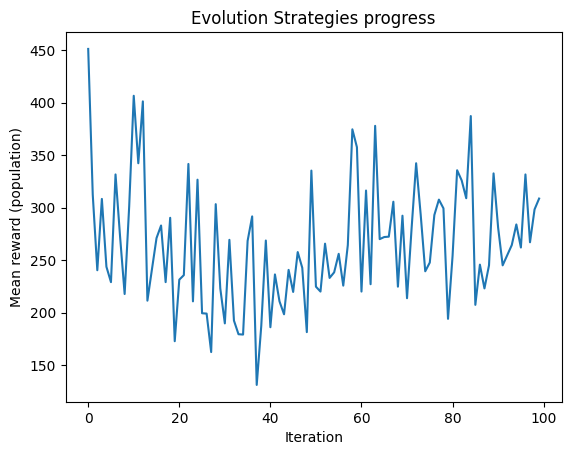

In [ ]:
plt.plot(es_rewards)
plt.xlabel("Iteration")
plt.ylabel("Mean reward (population)")
plt.title("Evolution Strategies progress")
plt.show()

1. **Start (first 10 iterations)**  
   – The average reward fluctuates strongly: from ~200 to over 400.  
   – This is because the initial population of random policies produces very different results.  

2. **Middle (10–60 iterations)**  
   – Average rewards are mostly in the 200–300 range.  
   – Fluctuations remain significant, with both drops (~150) and peaks (~350–400).  

3. **After 60 iterations**  
   – The method does not show stable growth.  
   – The average level stays around 250–300, occasionally going higher.  
   – No consistent improvement is observed, despite rare high values.  

4. **Overall trend**  
   – Evolution Strategies are better than pure Random Search since they use information from the population.  


## Launch of the best episodes of ES

[Evolution] Episode 1/50: reward=200.0
[Evolution] Episode 2/50: reward=230.0
[Evolution] Episode 3/50: reward=250.0
[Evolution] Episode 4/50: reward=270.0
[Evolution] Episode 5/50: reward=270.0
[Evolution] Episode 6/50: reward=210.0
[Evolution] Episode 7/50: reward=200.0
[Evolution] Episode 8/50: reward=340.0
[Evolution] Episode 9/50: reward=260.0
[Evolution] Episode 10/50: reward=340.0
[Evolution] Episode 11/50: reward=200.0
[Evolution] Episode 12/50: reward=320.0
[Evolution] Episode 13/50: reward=200.0
[Evolution] Episode 14/50: reward=220.0
[Evolution] Episode 15/50: reward=320.0
[Evolution] Episode 16/50: reward=220.0
[Evolution] Episode 17/50: reward=190.0
[Evolution] Episode 18/50: reward=340.0
[Evolution] Episode 19/50: reward=160.0
[Evolution] Episode 20/50: reward=180.0
[Evolution] Episode 21/50: reward=360.0
[Evolution] Episode 22/50: reward=220.0
[Evolution] Episode 23/50: reward=110.0
[Evolution] Episode 24/50: reward=280.0
[Evolution] Episode 25/50: reward=310.0
[Evolutio

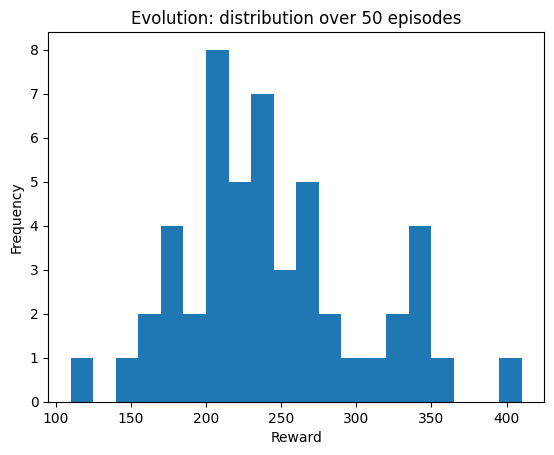

Top episodes ES: [28 20 27] Rewards: [410.0, 360.0, 340.0]


In [ ]:
# Load the trained policy
es_policy = Policy(env.action_space.n)
es_policy.load_state_dict(torch.load(save_path_es))
es_policy.eval()

# Play 50 episodes with video recording
rewards_es = evaluate("ALE/MsPacman-v5", es_policy, n_eval_episodes=50,
                      record_video=True, video_dir="/content/videos", name_prefix="Evolution")

# Find the top-3 episodes
top_k = 3
best_ids_es = np.argsort(rewards_es)[-top_k:][::-1]
print("Top episodes ES:", best_ids_es, "Rewards:", [rewards_es[i] for i in best_ids_es])

# Display videos of the best episodes
for idx in best_ids_es:
    video_path = f"/content/videos/Evolution-episode-{idx}.mp4"
    display(Video(video_path, embed=True))


# Conclusions

1. **Random Search**  
   – Average reward stays around 200–300.  
   – Behavior is highly random, with no improvements over time.  
   – Not suitable for stable policy learning.  

2. **Hill Climbing**  
   – Reward gradually increases but quickly hits a “ceiling” (~500).  
   – Performs better than random search but gets stuck in a local maximum.  
   – Can only be used as a simple heuristic.  

3. **Policy Gradient (REINFORCE)**  
   – Average rewards are higher than with random search and Hill Climbing.  
   – The learning curve is noisy, with many fluctuations.  
   – Occasionally achieves high scores (3000+), but cannot sustain them.  

4. **Evolution Strategies**  
   – Results are unstable, with rewards around 200–300.  
   – Worse than Hill Climbing and Policy Gradient.  

**Conclusion:** among the implemented approaches, the best was the **Policy Gradient method (REINFORCE)** — despite its noisiness, it can discover strategies that yield significantly higher rewards than simple evolutionary or random methods.  